# [ATM 623: Climate Modeling](../index.ipynb)

[Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany

# Lecture 24: Land-Ocean contrasts under climate change

### About these notes:

This document uses the interactive [`Jupyter notebook`](https://jupyter.org) format. The notes can be accessed in several different ways:

- The interactive notebooks are hosted on `github` at https://github.com/brian-rose/ClimateModeling_courseware
- The latest versions can be viewed as static web pages [rendered on nbviewer](http://nbviewer.ipython.org/github/brian-rose/ClimateModeling_courseware/blob/master/index.ipynb)
- A complete snapshot of the notes as of May 2017 (end of spring semester) are [available on Brian's website](http://www.atmos.albany.edu/facstaff/brose/classes/ATM623_Spring2017/Notes/index.html).

[Also here is a legacy version from 2015](http://www.atmos.albany.edu/facstaff/brose/classes/ATM623_Spring2015/Notes/index.html).

Many of these notes make use of the `climlab` package, available at https://github.com/brian-rose/climlab

## A recent tweet that caught my attention...

In [1]:
%%HTML
<blockquote class="twitter-tweet" data-lang="en"><p lang="en" dir="ltr">actual trends <a href="https://t.co/abnDJGeawr">pic.twitter.com/abnDJGeawr</a></p>&mdash; Gavin Schmidt (@ClimateOfGavin) <a href="https://twitter.com/ClimateOfGavin/status/1117136233409536000?ref_src=twsrc%5Etfw">April 13, 2019</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script> 

Statistics such as the global average or zonal average temperature do not tell the whole story about climate change!

## Some observational results on land-ocean warming differences from a recent paper

<img src='https://www.pnas.org/content/pnas/115/19/4863/F1.large.jpg' width="500">

> A–C) Surface-air annual (A) temperature, (B) specific humidity, and (C) relative humidity anomalies averaged from 40∘S to 40∘N and best-fit trends (1979–2016) over land (red solid lines and asterisks) and ocean (blue lines and asterisks). The best-fit trends in the land–ocean contrasts in temperature and specific humidity (δTL−δTO and δqL−δqO, respectively) are also plotted (black asterisks). Land values are from the HadISDH dataset (13, 14) and ocean values are from the ERA-Interim reanalysis (15). Ocean specific humidity anomalies are calculated assuming fixed climatological relative humidity (Materials and Methods). Also shown are land anomalies and associated trends (dashed lines and circles) estimated using the simple theory (Eqs. 2–4) and subsampled to the months and gridboxes for which HadISDH observations are available. Error bars on the trends indicate the 90% confidence intervals corrected to account for serial correlation (Materials and Methods).

Byrne and O'Gorman (2018): Trends in continental temperature and humidity directly linked to ocean warming, PNAS 115 (19) 4863-4868, https://doi.org/10.1073/pnas.1722312115

## Looking at land-ocean warming patterns in the CESM

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs

The following repeats the calculation we already did of the Equilibrium Climate Sensitity (ECS) and Transient Climate Response (TCR):

In [3]:
casenames = {'cpl_control': 'cpl_1850_f19',
             'cpl_CO2ramp': 'cpl_CO2ramp_f19',
             'som_control': 'som_1850_f19',
             'som_2xCO2':   'som_1850_2xCO2',
            }
# The path to the THREDDS server, should work from anywhere
basepath = 'http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/'
# For better performance if you can access the roselab_rit filesystem (e.g. from JupyterHub)
#basepath = '/roselab_rit/cesm_archive/'
casepaths = {}
for name in casenames:
    casepaths[name] = basepath + casenames[name] + '/concatenated/'
    
# make a dictionary of all the CAM atmosphere output
atm = {}
for name in casenames:
    path = casepaths[name] + casenames[name] + '.cam.h0.nc'
    print('Attempting to open the dataset ', path)
    atm[name] = xr.open_dataset(path, decode_times=False)

Attempting to open the dataset  http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/cpl_1850_f19/concatenated/cpl_1850_f19.cam.h0.nc
Attempting to open the dataset  http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/cpl_CO2ramp_f19/concatenated/cpl_CO2ramp_f19.cam.h0.nc
Attempting to open the dataset  http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/som_1850_f19/concatenated/som_1850_f19.cam.h0.nc
Attempting to open the dataset  http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/som_1850_2xCO2/concatenated/som_1850_2xCO2.cam.h0.nc


In [4]:
# extract the last 10 years from the slab ocean control simulation
nyears_som = 10
# and the last 20 years from the coupled control
nyears_cpl = 20
clim_slice_som = slice(-(nyears_som*12),None)
clim_slice_cpl = slice(-(nyears_cpl*12),None)

In [5]:
Tmap_cpl_2x = atm['cpl_CO2ramp'].TREFHT.isel(time=clim_slice_cpl).mean(dim='time')
Tmap_cpl_control = atm['cpl_control'].TREFHT.isel(time=clim_slice_cpl).mean(dim='time')
DeltaTmap_cpl = Tmap_cpl_2x - Tmap_cpl_control

Tmap_som_2x = atm['som_2xCO2'].TREFHT.isel(time=clim_slice_som).mean(dim='time')
Tmap_som_control = atm['som_control'].TREFHT.isel(time=clim_slice_som).mean(dim='time')
DeltaTmap_som = Tmap_som_2x - Tmap_som_control

In [6]:
def make_map(field, title=None):
    '''input field should be a 2D xarray.DataArray on a lat/lon grid.
        Make a filled contour plot of the field, and a line plot of the zonal mean
    '''
    fig = plt.figure(figsize=(14,6))
    nrows = 10; ncols = 3
    mapax = plt.subplot2grid((nrows,ncols), (0,0), colspan=ncols-1, rowspan=nrows-1, projection=ccrs.Robinson())
    barax = plt.subplot2grid((nrows,ncols), (nrows-1,0), colspan=ncols-1)
    plotax = plt.subplot2grid((nrows,ncols), (0,ncols-1), rowspan=nrows-1)
    cx = mapax.contourf(field.lon, field.lat, field, transform=ccrs.PlateCarree())
    mapax.set_global(); mapax.coastlines();
    plt.colorbar(cx, cax=barax, orientation='horizontal')
    plotax.plot(field.mean(dim='lon'), field.lat)
    plotax.set_ylabel('Latitude')
    plotax.grid()
    fig.suptitle(title, fontsize=16);
    return fig, (mapax, plotax, barax), cx

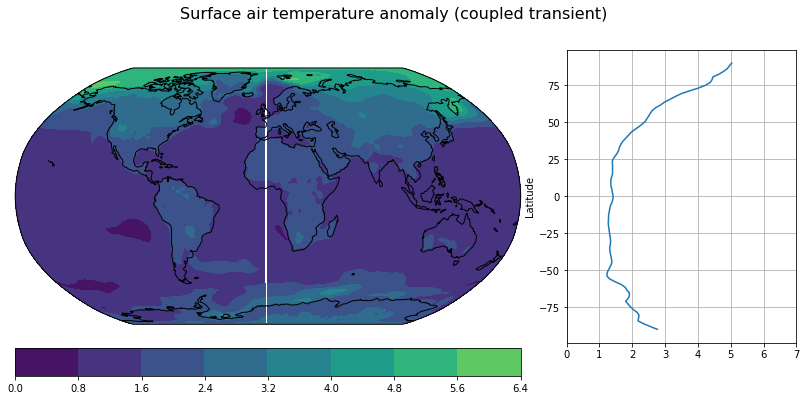

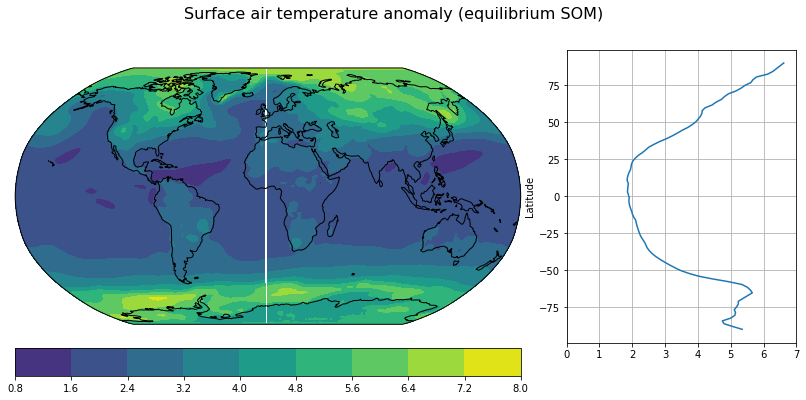

In [7]:
fig, axes, cx = make_map(DeltaTmap_cpl, title='Surface air temperature anomaly (coupled transient)')
axes[1].set_xlim(0,7)  # ensure the line plots have same axes
cx.set_clim([0, 8])    # ensure the contour maps have the same color intervals

fig, axes,cx  = make_map(DeltaTmap_som, title='Surface air temperature anomaly (equilibrium SOM)')
axes[1].set_xlim(0,7)
cx.set_clim([0, 8])

In [8]:
def global_mean(field, weight=atm['som_control'].gw):
    '''Return the area-weighted global average of the input field'''
    return (field*weight).mean(dim=('lat','lon'))/weight.mean(dim='lat')

ECS = global_mean(DeltaTmap_som)
TCR = global_mean(DeltaTmap_cpl)

print('The Equilibrium Climate Sensitivity is {:.3} K.'.format(float(ECS)))
print('The Transient Climate Response is {:.3} K.'.format(float(TCR)))

The Equilibrium Climate Sensitivity is 2.89 K.
The Transient Climate Response is 1.67 K.


Text(0.5, 0.98, 'Places that warm more than the global mean in CESM simulations')

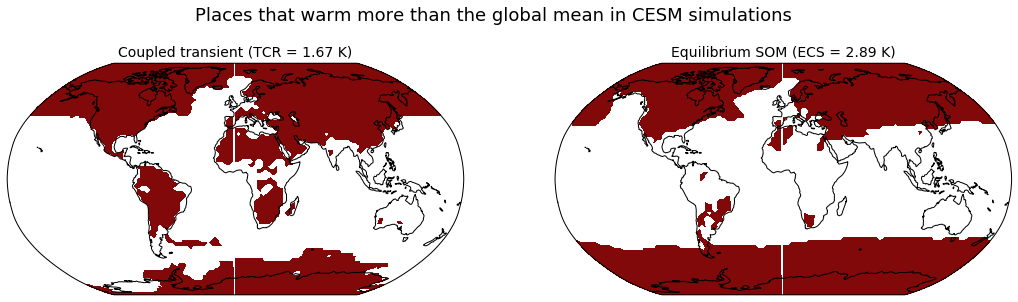

In [9]:
# Make a map like Gavin's...  places where warming is > global average
fig = plt.figure(figsize=(18,5))

ax1 = fig.add_subplot(1,2,1, projection=ccrs.Robinson())
ax1.contourf(DeltaTmap_cpl.lon, DeltaTmap_cpl.lat, 
             DeltaTmap_cpl.where(DeltaTmap_cpl>TCR), 
             levels=[0, 100], colors='#81090A',
             transform=ccrs.PlateCarree())
ax1.set_title('Coupled transient (TCR = {:.3} K)'.format(float(TCR)), fontsize=14)
ax2 = fig.add_subplot(1,2,2, projection=ccrs.Robinson())
ax2.contourf(DeltaTmap_som.lon, DeltaTmap_som.lat, 
             DeltaTmap_som.where(DeltaTmap_som>ECS), 
             levels=[0, 100], colors='#81090A',
             transform=ccrs.PlateCarree())
ax2.set_title('Equilibrium SOM (ECS = {:.3} K)'.format(float(ECS)), fontsize=14)

for ax in [ax1, ax2]:
    ax.set_global(); ax.coastlines();

fig.suptitle('Places that warm more than the global mean in CESM simulations', fontsize=18)

## Key Point

The **enhanced warming over land** is not just a feature of the transient, but is also found in the equilibrium response!

We cannot understand this result solely in terms of heat capacity differences.

**This motivates some detailed study of surface processes and the climatic coupling between land and ocean.**

## Plot the "land amplification factor"

Plot the time average warming over land **per unit zonally averaged warming of the surrounding oceans**

$$A \equiv \frac{\delta T_L}{\delta T_O} $$

where $\delta T_L$ is the near-surface air temperature increase **over land**, and $\delta T_O$ is the **zonally averaged** near-surface air temperature increase **over ocean**.

In [10]:
#  The land-ocean mask ... same for all simulations
landfrac = atm['cpl_control'].LANDFRAC.mean(dim='time')

/Users/br546577/anaconda3/envs/climlab-courseware/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


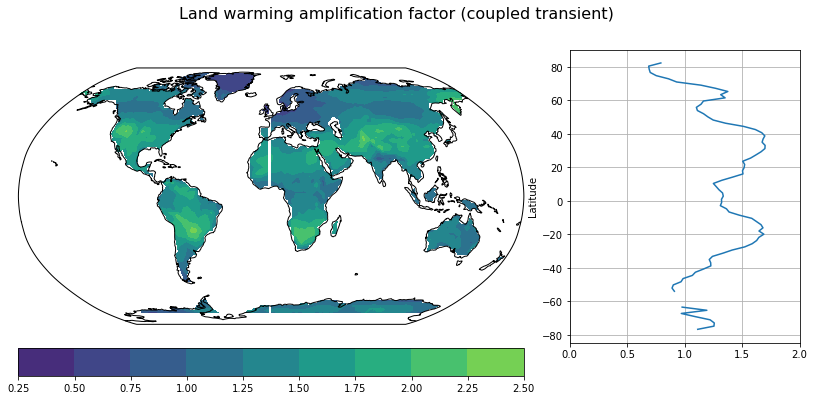

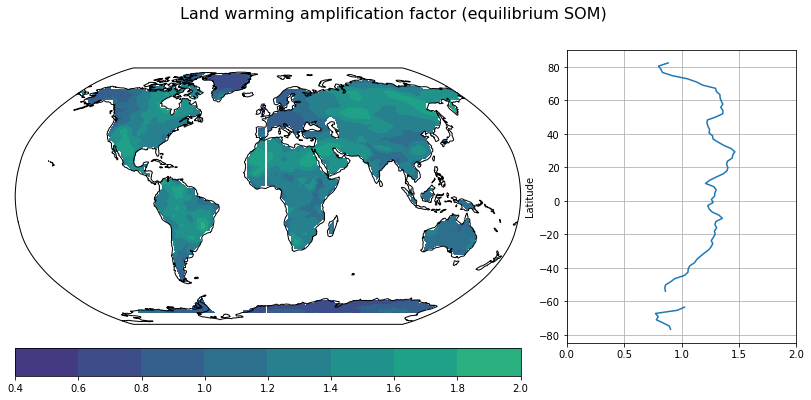

In [11]:
# Zonally averaged ocean warming
DeltaTO_cpl = DeltaTmap_cpl.where(landfrac<0.5).mean(dim='lon')
DeltaTO_som = DeltaTmap_som.where(landfrac<0.5).mean(dim='lon')

land_amplification_cpl = DeltaTmap_cpl.where(landfrac>0.5) / DeltaTO_cpl
land_amplification_som = DeltaTmap_som.where(landfrac>0.5) / DeltaTO_som

fig, axes, cx = make_map(land_amplification_cpl, title='Land warming amplification factor (coupled transient)');
axes[1].set_xlim(0,2)  # ensure the line plots have same axes
cx.set_clim([0, 3])    # ensure the contour maps have the same color intervals

fig, axes, cx = make_map(land_amplification_som, title='Land warming amplification factor (equilibrium SOM)');
axes[1].set_xlim(0,2)  # ensure the line plots have same axes
cx.set_clim([0, 3])    # ensure the contour maps have the same color intervals

## A simple theory for land-ocean warming contrast

This section is based on a series of papers by Byrne and O'Gorman:

- Byrne and O'Gorman (2013): Land–Ocean Warming Contrast over a Wide Range of Climates: Convective Quasi-Equilibrium Theory and Idealized Simulations. J. Clim. 26, https://journals.ametsoc.org/doi/full/10.1175/JCLI-D-12-00262.1
- Byrne and O'Gorman (2016): Understanding Decreases in Land Relative Humidity with Global Warming: Conceptual Model and GCM Simulations. J. Clim. 29, https://journals.ametsoc.org/doi/10.1175/JCLI-D-16-0351.1
- Byrne and O'Gorman (2018): Trends in continental temperature and humidity directly linked to ocean warming, PNAS 115 (19) 4863-4868, https://doi.org/10.1073/pnas.1722312115

### The atmospheric dynamics constraint

The dynamical argument has a few components:

- Frequent moist convection maintains a nearly moist-neutral lapse rate in the convectively active equatorial regions ("convective quasi-equilibrium").
- "Weak Temperature Gradient" theory for the low-latitude atmosphere asserts that air temperatures in the free troposphere are nearly homogeneous.
- Therefore the free troposphere is moist adiabatic everywhere.
- The differences between surface air temperature over land and ocean can be expressed in terms of different Lifting Condensation Levels (LCL):

<img src='https://journals.ametsoc.org/na101/home/literatum/publisher/ams/journals/content/clim/2013/15200442-26.12/jcli-d-12-00262.1/20130609/images/large/jcli-d-12-00262.1-f1.jpeg' width="300">

> Fig. 1. Schematic diagram of potential temperature vs height for moist adiabats over land and ocean and equal temperatures at upper levels. A land–ocean surface air temperature contrast is implied by different LCLs over land and ocean. 

> Byrne and O'Gorman (2013) J. Clim. 26, https://journals.ametsoc.org/doi/full/10.1175/JCLI-D-12-00262.1

A consequence of these constraints is that, under a climate change, the near-surface **moist static energy** content over land and ocean are equal:

$$ \delta h_L = \delta h_O $$

with the following standard notation:

- $h = c_p T + L_v q + g z_g$ is the moist static energy per unit mass
- $T$ is air temperature
- $q$ is the specific humidity
- $z_g$ is the geopotential height

From this we can infer that the **land warming amplification factor** is related to differences in boundary layer moistening:

$$ A \equiv \frac{\delta T_L}{\delta T_O} = 1 + \frac{L_v}{c_p} \frac{\delta q_O - \delta q_L}{\delta T_O} $$

which implies that there will be **greater warming over land than ocean** so long as *the moistening rate with warming over ocean is greater than over land*, $\delta q_O > \delta q_L$.

### The surface moisture constraint

This section is drawn directly from Byrne and O'Gorman (2016) J. Clim. 29, https://journals.ametsoc.org/doi/10.1175/JCLI-D-16-0351.1

Consider the following simple moisture budgets for the boundary layers over ocean and over land:

<img src='https://journals.ametsoc.org/na101/home/literatum/publisher/ams/journals/content/clim/2016/15200442-29.24/jcli-d-16-0351.1/20161201/images/large/jcli-d-16-0351.1-f2.jpeg' width="500">

> Fig. 2. Schematic diagram of processes involved in the moisture budget of the boundary layer above a land surface [see text and (1) for definitions of the various quantities].

The budget over land is

$$ l h_L \frac{d q_L}{dt} = h_O v_1 (q_O - q_L) + (h_L - h_O) v_1 (q_{FT,O} - q_L) + l v_2 (q_{FT,L} - q_L ) + \frac{1}{\rho_a} E_L $$

where 

- $l$ is the horizontal length scale of the land
- $h_L, h_O$ are the boundary layer depths
- $v_1, v_2$ are the horizontal and vertical mixing velocities
- $q_{FT,L}, q_{FT,O}$ are the free-tropospheric specific humidities above the boundary layers
- $\rho_a$ is the density of air
- $E_L$ is the evapotranspiration from the land surface

The source terms on the RHS are respectively horizontal mixing of boundary layer air, horizontal mixing of free-tropospheric air, vertical mixing, and surface fluxes.

Now assume that free-tropospheric moisture is proportional to boundary layer moisture:

\begin{align*}
q_{FT,L} &= \lambda_L q_L  &  q_{FT,O} &= \lambda_O q_O
\end{align*}

Setting the LHS of the moisture budget to zero, we can solve the steady-state budget for land specific humidity $q_L$:

$$ q_L = \frac{\left[ h_O + \lambda_O ( h_L - h_O)\right] \tau_2}{h_L\left[\tau_1(1-\lambda_L) + \tau_2 \right]} q_O + \frac{\tau_1 \tau_2 }{\rho_a h_L \left[ \tau_1(1-\lambda_L) + \tau_2 \right]} E_L $$

where for convenience we have defined horizontal and vertical mixing timescales

\begin{align*}
\tau_1 &= \frac{l}{v_1}  &  \tau_2 &= \frac{h_L}{v_2} 
\end{align*}

The two terms above quantify the relative importance of remote ocean specific humidity and local evapotransipiration on land specific humidity. We can rewrite this as

$$ q_L = \gamma q_O + q_E $$

### The "Ocean-influence" box model

The simplest form of the moisture constraint comes from assuming that the influence of evapotranspiration on boundary layer specific humidity over land is negligible. 

Setting $E_L = 0$ we get simply

$$ q_L = \gamma q_O$$

where the proportionality is

$$\gamma = \frac{\left[ h_O + \lambda_O ( h_L - h_O)\right] \tau_2}{h_L\left[\tau_1(1-\lambda_L) + \tau_2 \right]} $$

We now make one more assumption: the proportionality $\gamma$ remains constant under climate change. Then changes in boundary specific humidity are related through

$$\delta q_L = \gamma \delta q_O $$

where the constant can be evaluated from the reference climate:

$$ \gamma = \frac{\overline{q_L}}{\overline{q_O}} $$



### Combined theory: dynamic and moisture constraints

Combining the dynamic and moisture constraints gives the change in land warming amplification factor **solely in terms of the ocean warming and moistening*:

$$ A \equiv \frac{\delta T_L}{\delta T_O}  = 1 + \frac{L_v}{c_p} (1-\gamma) \frac{\delta q_O}{\delta T_O} $$

which implies that there will be **greater warming over land than ocean** so long as the land surface is drier than the ocean surface ($\gamma < 1$) and the air gets moister with warming over the ocean ($\delta q_O > 0$).

Notice that with the combined constraints we are able to make this prediction without using an information about the land surface conditions other than the reference specific humidity (parameter $\gamma$).

### Relative humidity changes over land

The **relative humidity** is well approximated by

$$ r = \frac{q}{q^*} $$

(over land or ocean) where $q^*$ is the relevant **saturation** specific humidity.

For small climate changes we can thus write *fractional* changes in relative humidity as

$$ \frac{\delta r}{r} \approx \frac{\delta q}{q} - \frac{\delta q^*}{q^*}$$

and the fractional change in saturation is governed by the Clausius-Clapeyron relation, which is well approximated by

$$ \frac{\delta q^*}{q^*} \approx \alpha \delta T $$

with the CC rate

$$ \alpha = \frac{L_v}{R_v T^2} \approx 6 \% / K $$

We typically assume that **relative humidity remains constant over the ocean**, so $\frac{\delta r_O}{r_O} = 0$ and thus

$$\frac{\delta q_O}{q_O} = \alpha \delta T_O $$

while over land we find instead

$$ \frac{\delta r_L}{r_L} \approx \frac{\delta q_L}{q_L} - \alpha \delta T_L $$

An implication of the moisture constraint above is that the **fractional** changes in specific humidity must be the same over land and ocean:

$$ \frac{\delta q_L}{q_L} = \frac{\delta q_O}{q_O} = \alpha \delta T_O $$

Combining this with the dynamic constraint then gives

$$ \frac{\delta r_L}{r_L} \approx - \alpha (1-\gamma) \frac{L_v}{c_p} \delta q_O $$

The conclusion is that **the relative humidity over land must decrease** along with the amplified warming over land.

See Byrne and O'Gorman (2016) for discussion and caveats.

## Evaluation of simple land amplification theory

To summarize the above derivations:

1. The dynamic constraint gives the amplification factor $A$ as

$$ A \equiv \frac{\delta T_L}{\delta T_O} = 1 + \frac{L_v}{c_p} \frac{\delta q_O - \delta q_L}{\delta T_O} $$

while 

2. the moisture constraint (in its simplest form) gives

\begin{align*}
\delta q_L &= \gamma \delta q_O  \\
\gamma &= \frac{\overline{q_L}}{\overline{q_O}}
\end{align*}

so that the amplification factor is simply
$$ A = 1 + \frac{L_v}{c_p} (1-\gamma) \frac{\delta q_O}{\delta T_O} $$

We are going to evaluate this theory quantitatively against the CESM simulations.

In [12]:
from climlab.utils.constants import Lhvap, cp, Rv

def land_amp(deltaQO, deltaQL, deltaTO):
    return 1 + Lhvap/cp*(deltaQO - deltaQL)/deltaTO

/Users/br546577/anaconda3/envs/climlab-courseware/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


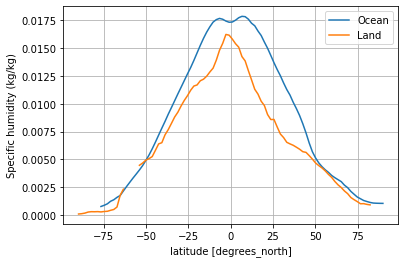

In [13]:
# Look at zonally averaged specific humidity over land and ocean
qL = atm['cpl_control'].QREFHT.where(landfrac>0.5).isel(time=clim_slice_cpl).mean(dim=('time', 'lon'))
qO = atm['cpl_control'].QREFHT.where(landfrac<0.5).isel(time=clim_slice_cpl).mean(dim=('time', 'lon'))

qO.plot(label='Ocean')
qL.plot(label='Land')
plt.legend(); plt.grid();
plt.ylabel('Specific humidity (kg/kg)');

### Amplification factors using dynamic constraint only

In [14]:
#  Compute changes in specific humidity
Qmap_cpl_2x = atm['cpl_CO2ramp'].QREFHT.isel(time=clim_slice_cpl).mean(dim='time')
Qmap_cpl_control = atm['cpl_control'].QREFHT.isel(time=clim_slice_cpl).mean(dim='time')
DeltaQmap_cpl = Qmap_cpl_2x - Qmap_cpl_control

Qmap_som_2x = atm['som_2xCO2'].QREFHT.isel(time=clim_slice_som).mean(dim='time')
Qmap_som_control = atm['som_control'].QREFHT.isel(time=clim_slice_som).mean(dim='time')
DeltaQmap_som = Qmap_som_2x - Qmap_som_control

Text(0, 0.5, 'kg/kg/K')

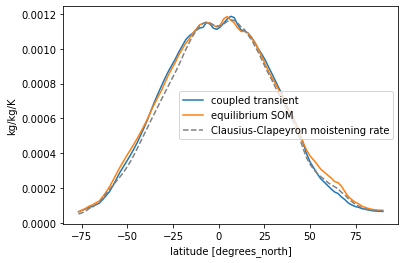

In [15]:
# Increase in specific humidity over oceans per degree warming
DeltaQO_cpl = DeltaQmap_cpl.where(landfrac<0.5).mean(dim='lon')
DeltaQO_som = DeltaQmap_som.where(landfrac<0.5).mean(dim='lon')

(DeltaQO_cpl / DeltaTO_cpl).plot(label='coupled transient')
(DeltaQO_som / DeltaTO_som).plot(label='equilibrium SOM')
# Simple estimate of the moistening rate from Clausius-Clapeyron
alpha = Lhvap/Rv/288**2
(alpha * qO).plot(label='Clausius-Clapeyron moistening rate', linestyle='--', color='grey')
plt.legend();
plt.ylabel('kg/kg/K')

Notice that the normalized humidity increase is nearly identical in the two models, and very well predicted by Clausius-Clapeyron.

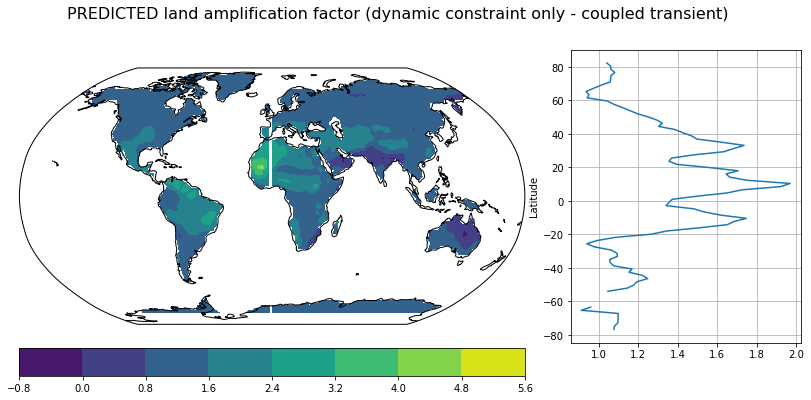

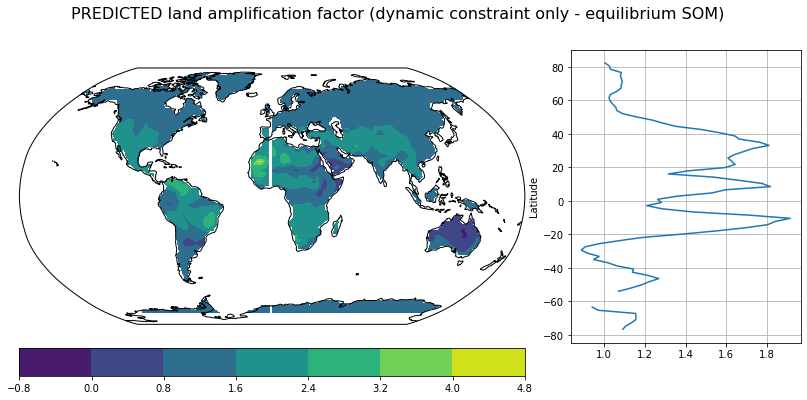

In [16]:
# Compute the land amplification factor based on dynamic constraint only
#  Note that this requires knowledge of actual specific humidity changes over land

predicted_land_amplification_cpl = land_amp(DeltaQO_cpl, DeltaQmap_cpl.where(landfrac>0.5), DeltaTO_cpl)
predicted_land_amplification_som = land_amp(DeltaQO_som, DeltaQmap_som.where(landfrac>0.5), DeltaTO_som)

make_map(predicted_land_amplification_cpl, 
        title='PREDICTED land amplification factor (dynamic constraint only - coupled transient)');
make_map(predicted_land_amplification_som,
        title='PREDICTED land amplification factor (dynamic constraint only - equilibrium SOM)');

### Amplification factors using dynamic + moisture constraint

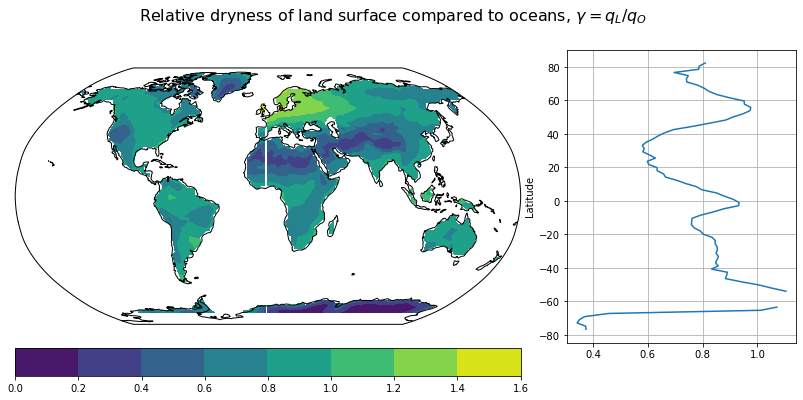

In [17]:
# Make a map of the "gamma" factor, ratio of land specific humidity to surrounding oceans
qL_map = atm['cpl_control'].QREFHT.where(landfrac>0.5).isel(time=clim_slice_cpl).mean(dim=('time'))
gamma_map = qL_map / qO
make_map(gamma_map, 'Relative dryness of land surface compared to oceans, $\gamma = q_L / q_O$');

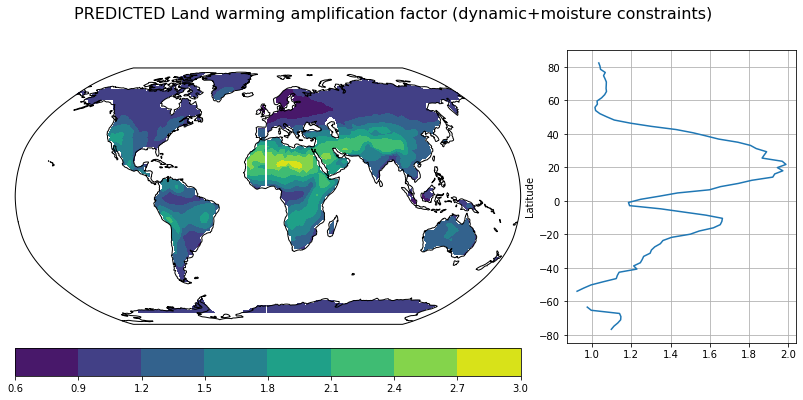

In [18]:
predicted_land_amplification_simple = land_amp(DeltaQO_cpl, gamma_map*DeltaQO_cpl, DeltaTO_cpl)
make_map(predicted_land_amplification_simple,
        title='PREDICTED Land warming amplification factor (dynamic+moisture constraints)');

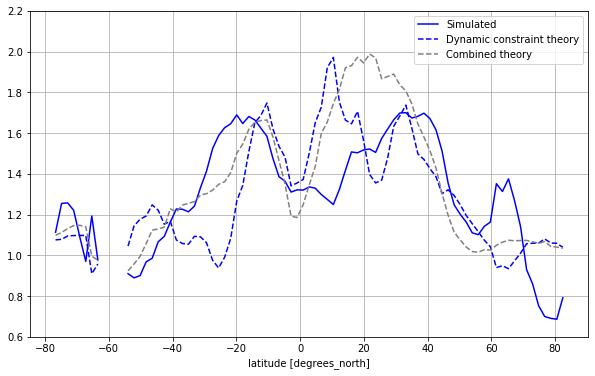

In [19]:
# Summarize the zonal average results (Plot coupled model only)
plt.figure(figsize=(10,6))
land_amplification_cpl.mean(dim='lon').plot(label='Simulated', color='blue')
predicted_land_amplification_cpl.mean(dim='lon').plot(label='Dynamic constraint theory', 
                                                      color='blue', linestyle='--')
predicted_land_amplification_simple.mean(dim='lon').plot(label='Combined theory', linestyle='--', color='grey')
plt.legend();
plt.grid();
plt.ylim(0.6, 2.2);

Compare to CMIP5 multi-model mean:

<img src='https://journals.ametsoc.org/na101/home/literatum/publisher/ams/journals/content/clim/2016/15200442-29.24/jcli-d-16-0351.1/20161201/images/large/jcli-d-16-0351.1-fa1.jpeg' width="400">

> Fig. B1. The CMIP5 multimodel mean (a) land–ocean warming contrast (expressed as an amplification factor) and (b) surface-air land pseudo relative humidity change normalized by the global-mean surface-air temperature change (solid lines) and as estimated by the combined moisture and dynamic constraints (dashed lines). The amplification factor and land relative humidity changes are estimated for each land grid point and for each month of the year before taking the zonal and annual means.

Byrne and O'Gorman (2016) J. Clim. 29, https://journals.ametsoc.org/doi/10.1175/JCLI-D-16-0351.1


Our results are consistent with Byrne and O'Gorman in that the simple theory captures the amplification signal in the **southern subtropics** quite well, but strongly overestimates the amplifcation in the **northern subtropics**.

The simple "ocean influence" theory works best in the hemisphere dominated by ocean!

We may get more insight into the weaknesses of the theory by looking more carefully at the relative humidity changes, and the role of land-surface evaporation changes (neglected under the "ocean-influence" theory).

## Critical evaluation of assumptions

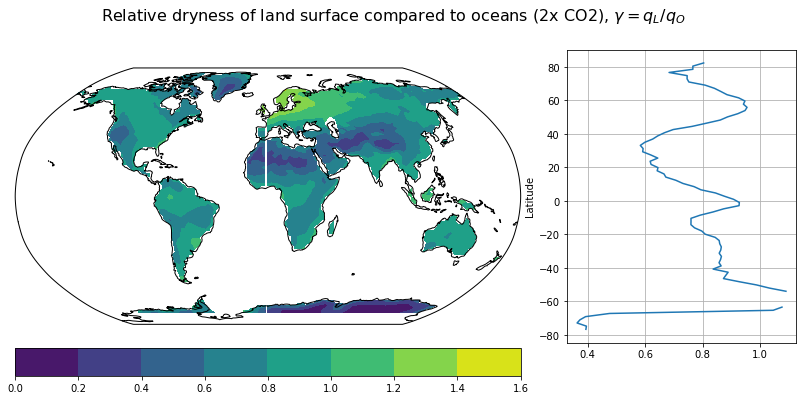

In [20]:
# Recompute gamma for the warmer climate.
# We assumed it did not change with global warming

# Look at zonally averaged specific humidity over land and ocean
qL_2x = atm['cpl_CO2ramp'].QREFHT.where(landfrac>0.5).isel(time=clim_slice_cpl).mean(dim=('time', 'lon'))
qO_2x = atm['cpl_CO2ramp'].QREFHT.where(landfrac<0.5).isel(time=clim_slice_cpl).mean(dim=('time', 'lon'))

# Make a map of the "gamma" factor, ratio of land specific humidity to surrounding oceans
qL_map_2x = atm['cpl_CO2ramp'].QREFHT.where(landfrac>0.5).isel(time=clim_slice_cpl).mean(dim=('time'))
gamma_map_2x = qL_map_2x / qO_2x
make_map(gamma_map_2x, 'Relative dryness of land surface compared to oceans (2x CO2), $\gamma = q_L / q_O$');

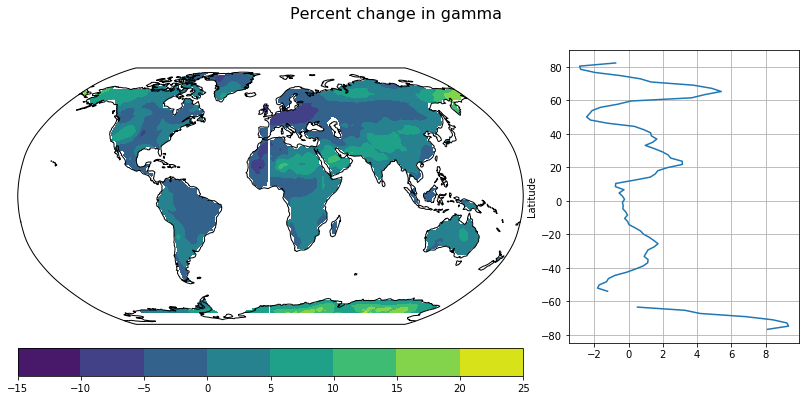

In [21]:
# Plot the percentage change
make_map((gamma_map_2x-gamma_map)/gamma_map * 100, title='Percent change in gamma');

The error is pretty small.

### Relative humidity change

In [22]:
RHmap = atm['cpl_control'].RELHUM.isel(lev=-1, time=clim_slice_cpl).mean(dim='time')
RHmap_2x = atm['cpl_CO2ramp'].RELHUM.isel(lev=-1, time=clim_slice_cpl).mean(dim='time')
DeltaRHmap = RHmap_2x - RHmap

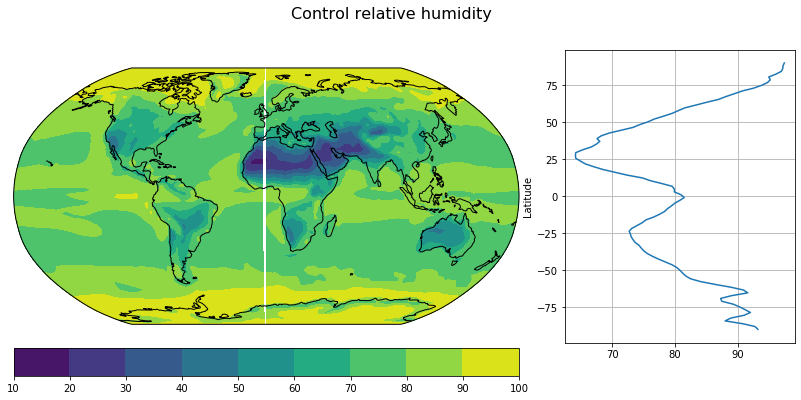

In [23]:
make_map(RHmap, title='Control relative humidity');

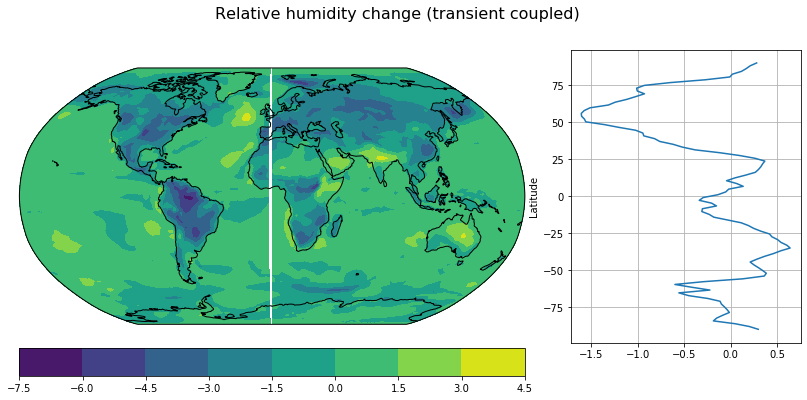

In [24]:
make_map(DeltaRHmap, title='Relative humidity change (transient coupled)');

Looks like a big source of error in the simple estimates of land amplification here is the unexpected relative moistening over the arid regions of North Africa and Arabia.

____________
## Version information
____________

In [25]:
%load_ext version_information
%version_information numpy, matplotlib, xarray, cartopy, climlab

Loading extensions from ~/.ipython/extensions is deprecated. We recommend managing extensions like any other Python packages, in site-packages.


Software versions
Python 3.7.3 64bit [Clang 4.0.1 (tags/RELEASE_401/final)]
IPython 7.6.0
OS Darwin 17.7.0 x86_64 i386 64bit
numpy 1.16.4
matplotlib 3.1.1
xarray 0.12.1
cartopy 0.17.0
climlab 0.7.5
Wed Jul 03 14:58:44 2019 EDT

____________

## Credits

The author of this notebook is [Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany.

It was developed in support of [ATM 623: Climate Modeling](http://www.atmos.albany.edu/facstaff/brose/classes/ATM623_Spring2015/), a graduate-level course in the [Department of Atmospheric and Envionmental Sciences](http://www.albany.edu/atmos/index.php)

Development of these notes and the [climlab software](https://github.com/brian-rose/climlab) is partially supported by the National Science Foundation under award AGS-1455071 to Brian Rose. Any opinions, findings, conclusions or recommendations expressed here are mine and do not necessarily reflect the views of the National Science Foundation.
____________